# <font color='red'>Clustering Assignment</font>

**There will be some functions that start with the word "grader" ex: grader_actors(), grader_movies(), grader_cost1() etc, you should not change those function definition.<br><br>Every Grader function has to return True.**

**Please check [clustering assignment helper functions](https://drive.google.com/file/d/1V29KhKo3YnckMX32treEgdtH5r90DIjU/view?usp=sharing) notebook before attempting this assignment.**

*  Read graph from the given <font color='blue'>movie_actor_network.csv</font> (note that the graph is bipartite graph.)

*  Using stellergaph and gensim packages, get the dense representation(128dimensional vector) of every node in the graph. [Refer <font color='blue'>Clustering_Assignment_Reference.ipynb</font>]

* Split the dense representation into actor nodes, movies nodes.(Write you code in <font color='blue'>def data_split()</font>)


# <font color='red'>Task 1 : Apply clustering algorithm to group similar actors</font>

 1. For this task consider only the actor nodes 
 2. Apply any clustering algorithm of your choice <br>
    Refer : https://scikit-learn.org/stable/modules/clustering.html
 3. Choose the number of clusters for which you have maximum score of <b>$Cost1*Cost2$</b><br>
 4. Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters 
<br> (Write your code in <font color='blue'>def cost1()</font>)<br>
 5. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 
 <br> (Write your code in <font color='blue'>def cost2()</font>)<br>
 6. Fit the clustering algorithm with the opimal number_of_clusters and get the cluster number for each node <br>
 7. Convert the d-dimensional dense vectors of nodes into 2-dimensional using dimensionality reduction techniques (preferably TSNE)<br>
 8. Plot the 2d scatter plot, with the node vectors after step e and give colors to nodes such that same cluster nodes will have same color

<img src='https://i.imgur.com/4SPYPFa.jpg'>

# <font color='red'>Task 2 : Apply clustering algorithm to group similar movies</font>


1. For this task consider only the movie nodes
2. Apply any clustering algorithm of your choice
3.Choose the number of clusters for which you have maximum score of $Cost1*Cost2$ <br>

    Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br>
(Write your code in <font color='blue'>def cost1()</font>)<br>
	
4. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of movie nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(number of unique actor nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}$ 
where N= number of clusters 
<br>(Write your code in <font color='blue'>def cost2()</font>)<br>


**Algorithm for actor nodes**

<pre>
	for number_of_clusters in [3, 5, 10, 30, 50, 100, 200, 500]:
		algo = clustering_algorith(clusters=number_of_clusters)
        # you will be passing a matrix of size N*d where N number of actor nodes and d is dimension from gensim
		algo.fit(the dense vectors of actor nodes) 
        You can get the labels for corresponding actor nodes (algo.labels_)
        Create a graph for every cluster(ie., if n_clusters=3, create 3 graphs)
        (You can use ego_graph to create subgraph from the actual graph)
        compute cost1,cost2 
           (if n_cluster=3, cost1=cost1(graph1)+cost1(graph2)+cost1(graph3) # here we are doing summation
            cost2=cost2(graph1)+cost2(graph2)+cost2(graph3)
		computer the metric Cost = Cost1*Cost2
	return number_of_clusters which have maximum Cost
	</pre>

<br>

In [1]:
#!pip install networkx==2.3

In [2]:
#!pip install stellargraph

In [99]:
%matplotlib inline
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
# you need to have tensorflow 
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph

In [100]:
#data=pd.read_csv('movie_actor_network.csv', index_col=False, names=['movie','actor'])

For Google Colab

In [101]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [102]:
data=pd.read_csv('/content/drive/MyDrive/14 Clustering on Graph Dataset/movie_actor_network.csv', index_col=False, names=['movie','actor'])

In [103]:
edges = [tuple(x) for x in data.values.tolist()]

In [104]:
B = nx.Graph()
B.add_nodes_from(data['movie'].unique(), bipartite=0, label='movie')
B.add_nodes_from(data['actor'].unique(), bipartite=1, label='actor')
B.add_edges_from(edges, label='acted')

In [105]:
A = list(nx.connected_component_subgraphs(B))[0]

In [106]:
#A = (B.subgraph(c) for c in nx.connected_components(B))
#A = list(A)[0]

In [107]:
print("number of nodes", A.number_of_nodes())
print("number of edges", A.number_of_edges())

number of nodes 4703
number of edges 9650


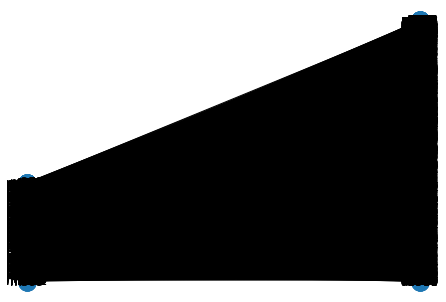

In [108]:
l, r = nx.bipartite.sets(A)
pos = {}

pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
  
nx.draw(A, pos=pos, with_labels=True)
plt.show()

In [109]:
movies = []
actors = []
for i in A.nodes():
    if 'm' in i:
        movies.append(i)
    if 'a' in i:
        actors.append(i)
print('number of movies ', len(movies))
print('number of actors ', len(actors))

number of movies  1292
number of actors  3411


In [110]:

# Create the random walker
rw = UniformRandomMetaPathWalk(StellarGraph(A))

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["movie", "actor", "movie"],
    ["actor", "movie", "actor"]
]

walks = rw.run(nodes=list(A.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=1,        # number of random walks per root node 
               metapaths=metapaths
              )

print("Number of random walks: {}".format(len(walks)))

Number of random walks: 4703


In [111]:
from gensim.models import Word2Vec
model = Word2Vec(walks, size=128, window=5)

In [112]:
model.wv.vectors.shape  # 128-dimensional vector for each node in the graph

(4703, 128)

In [113]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ A.node[node_id]['label'] for node_id in node_ids]

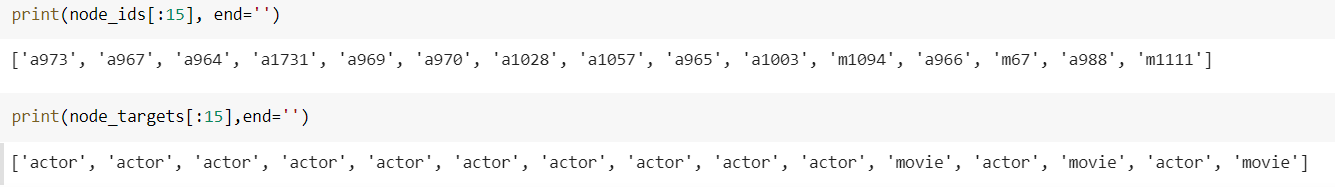

In [114]:
def data_split(node_ids,node_targets,node_embeddings):
    '''In this function, we will split the node embeddings into actor_embeddings , movie_embeddings '''
    actor_nodes,movie_nodes=[],[]
    actor_embeddings,movie_embeddings=[],[]
    # split the node_embeddings into actor_embeddings,movie_embeddings based on node_ids
    # By using node_embedding and node_targets, we can extract actor_embedding and movie embedding
    # By using node_ids and node_targets, we can extract actor_nodes and movie nodes
    actor_nodes,movie_nodes=[],[]
    actor_embeddings,movie_embeddings=[],[]
    actor_target, movie_target = [], []

    for i in range(len(node_targets)):
      if node_targets[i] == 'actor':
        actor_nodes.append(node_ids[i])
        actor_embeddings.append(node_embeddings[i])
        actor_target.append(node_targets[i])
      else:
        movie_nodes.append(node_ids[i])
        movie_embeddings.append(node_embeddings[i])
        movie_target.append(node_targets[i])
    return actor_nodes,movie_nodes,actor_embeddings,movie_embeddings


In [115]:
actor_nodes,movie_nodes,actor_embeddings,movie_embeddings = data_split(node_ids,node_targets,node_embeddings)


<font color='cyan'>Grader function - 1</font>

In [116]:
def grader_actors(data):
    assert(len(data)==3411)
    return True
grader_actors(actor_nodes)

True

<font color='cyan'>Grader function - 2</font>

In [117]:
def grader_movies(data):
    assert(len(data)==1292)
    return True
grader_movies(movie_nodes)

True

<font color='blue'>Calculating cost1</font>

Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br><br>
<br>

In [118]:
import operator as op
def cost1(graded_graph,k):
  actor_node_list = [i for i in graded_graph.node if 'a' in i]
  total_nodes_in_cluster = len(set(list(graded_graph.nodes())))
  nodewise_connected_ele = []
  for i in actor_node_list:
    selected_node_graph = nx.ego_graph(graded_graph, i)
    #print(selected_node_graph.nodes())
    connected_nodes = len(selected_node_graph.nodes())
    nodewise_connected_ele.append(len(selected_node_graph.nodes()))

  nodewise_connected_ele

  #Now select node with max xonnected components
  #print(dict(zip(actor_node_list, nodewise_connected_ele)))

  cluster_cost1 = op.truediv(max(nodewise_connected_ele),(total_nodes_in_cluster))
  cluster_cost1 = op.truediv(cluster_cost1 , k)

  return cluster_cost1

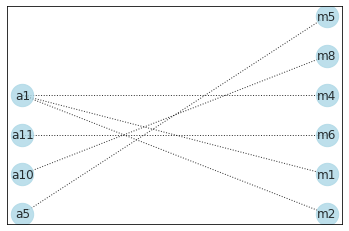

In [119]:
import networkx as nx
from networkx.algorithms import bipartite
graded_graph= nx.Graph()
graded_graph.add_nodes_from(['a1','a5','a10','a11'], bipartite=0) # Add the node attribute "bipartite"
graded_graph.add_nodes_from(['m1','m2','m4','m6','m5','m8'], bipartite=1)
graded_graph.add_edges_from([('a1','m1'),('a1','m2'),('a1','m4'),('a11','m6'),('a5','m5'),('a10','m8')])
l={'a1','a5','a10','a11'};r={'m1','m2','m4','m6','m5','m8'}
pos = {}
pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
nx.draw_networkx(graded_graph, pos=pos, with_labels=True,node_color='lightblue',alpha=0.8,style='dotted',node_size=500)

<font color='cyan'>Grader function - 3</font>

In [120]:
graded_cost1=cost1(graded_graph,3)
def grader_cost1(data):
    assert(data==((1/3)*(4/10))) # 1/3 is number of clusters
    return True
grader_cost1(graded_cost1)

True

<font color='blue'>Calculating cost2</font>

Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 

In [121]:
def cost2(graded_graph, k):

  '''In this function, we will calculate cost1'''

  #Select all the actor nodes from the actor data
  actor_node_list = [a for a in graded_graph.node if 'a' in a]

  #create Empty Graph
  cluster_graph=nx.Graph()

  #For each node in actor nodes, create ego graph and add node+edge info to cluster graph
  for i in actor_node_list:
    selected_node_graph = nx.ego_graph(graded_graph, i)
    cluster_graph.add_nodes_from(selected_node_graph.nodes())
    cluster_graph.add_edges_from(selected_node_graph.edges())
  
  #nx.draw(cluster_graph, with_labels = True)

  actor_node_list = [a for a in cluster_graph.node if 'a' in a] 
  #print(actor_node_list)
  movie_node_list = [m for m in cluster_graph.node if 'm' in m]
  #print(movie_node_list)

  cluster_cost2 = op.truediv(len(list(cluster_graph.edges)),len(movie_node_list))
  cluster_cost2 = op.truediv(cluster_cost2 , k)

  return cluster_cost2

<font color='cyan'>Grader function - 4</font>

In [122]:
graded_cost2=cost2(graded_graph,3)
def grader_cost2(data):
    assert(data==((1/3)*(6/6))) # 1/3 is number of clusters
    return True
grader_cost2(graded_cost2)

True

<font color='blue'>Grouping similar actors</font>

In [123]:

from tqdm import tqdm
k_list = [3, 5, 10, 30, 50, 100, 200, 500]

final_cost_list = []

#Selecting each value of k
for k in tqdm(k_list):
  K_means = KMeans(n_clusters=k, random_state=1, n_jobs=-1)
  K_means.fit(actor_embeddings)

  actor_df = pd.DataFrame(data=[actor_nodes] )
  actor_df = pd.DataFrame(actor_df.T) 
  actor_df['actor_embeddings'] = actor_embeddings
  actor_df['cluster_no'] = list(K_means.labels_)
  actor_df.columns = ['actor_nodes', 'actor_embeddings', 'cluster_no']

  #HERE need to select all clusters one-by-one

  cluster_names = []
  for i in range(k):
    cluster_names.append(str('cluster_')+str(i))
  #cluster_names

  clusters_list = []
  for i in range(k):
    cluster_names[i] = pd.DataFrame(actor_df[actor_df.cluster_no==i])
    clusters_list.append(cluster_names[i])

  #select each cluster for all k
  for selected_cluster in clusters_list:
    cost1_list, cost2_list = [],[]

    #create Empty Graph
    selected_cluster_graph=nx.Graph()

    actor_node_list = list(selected_cluster.actor_nodes)

    #For each node in actor nodes, create ego graph and add node+edge info to cluster graph
    for i in actor_node_list:
      selected_node_graph = nx.ego_graph(A, i)
      selected_cluster_graph.add_nodes_from(selected_node_graph.nodes())
      selected_cluster_graph.add_edges_from(selected_node_graph.edges())
      
    #Visualizing Graph
    #nx.draw(selected_cluster_graph, with_labels=True)

    selected_cluster_cost1 = cost1(selected_cluster_graph, k)
    cost1_list.append(selected_cluster_cost1)

    selected_cluster_cost2 = cost2(selected_cluster_graph, k)
    cost2_list.append(selected_cluster_cost2)
  
  final_cost = sum(cost1_list) * sum(cost2_list)
  final_cost_list.append(final_cost)

k_cost = (dict(zip(k_list, final_cost_list)))
best_k = k_list[final_cost_list.index(max(final_cost_list))]
print("k = {0} gives max cost i.e. {1} ".format(best_k, max(final_cost_list)))
print(k_cost)
print("Best Value of k :", best_k)




100%|██████████| 8/8 [00:41<00:00,  5.13s/it]

k = 3 gives max cost i.e. 0.0935115093996007 
{3: 0.0935115093996007, 5: 0.009967576515859552, 10: 0.015126085543119864, 30: 0.0005366789347756835, 50: 0.0004, 100: 0.0001, 200: 2.5e-05, 500: 2.653846153846154e-06}
Best Value of k : 3


Now train model with best K.

In [124]:
K_means = KMeans(n_clusters=best_k, random_state=1, n_jobs=-1)
K_means.fit(actor_embeddings)

actor_df = pd.DataFrame(data=[actor_nodes] )
actor_df = pd.DataFrame(actor_df.T) 
#actor_df['actor_embeddings'] = actor_embeddings
actor_df['cluster_no'] = list(K_means.labels_)
actor_df.columns = ['actor_nodes', 'cluster_no']

actor_df

,actor_nodes,cluster_no
0,a973,2
1,a967,2
2,a964,2
3,a1731,2
4,a970,2
...,...,...
3406,a1990,1
3407,a1624,1
3408,a2152,1
3409,a1263,1


Now the task is to display each cluster with different color.

<font color='blue'>Displaying similar actor clusters</font>

In [125]:
from sklearn.manifold import TSNE
transform = TSNE #PCA

trans = transform(n_components=2)
actor_embeddings_2d = trans.fit_transform(actor_embeddings)

In [126]:
trial = pd.DataFrame(actor_embeddings_2d)
trial.columns = ['x', 'y']
trial['cluster_no'] = list(K_means.labels_)
trial

,x,y,cluster_no
0,-59.311085,15.375273,2
1,-58.056496,21.319038,2
2,-59.733837,15.557880,2
3,0.578625,64.590424,2
4,-59.396622,17.393166,2
...,...,...,...
3406,-22.048473,-3.789406,1
3407,-7.183355,25.884834,1
3408,-22.616083,-3.582985,1
3409,-7.055651,28.220812,1


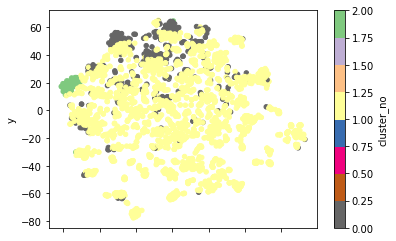

In [127]:
trial.plot.scatter(x='x',
                      y='y',
                      c='cluster_no',
                      colormap='Accent_r')

In [128]:
#Generating dataset for 3D Scatter Plot


'''trans = transform(n_components=3)
actor_embeddings_3d = trans.fit_transform(actor_embeddings)

trial_3D = pd.DataFrame(actor_embeddings_3d)
trial_3D.columns = ['D1', 'D2', 'D3']
trial_3D['cluster_no'] = list(K_means.labels_)


from google.colab import files
trial_3D.to_csv('actors_3D.csv') 
files.download('actors_3D.csv')'''

"trans = transform(n_components=3)\nactor_embeddings_3d = trans.fit_transform(actor_embeddings)\n\ntrial_3D = pd.DataFrame(actor_embeddings_3d)\ntrial_3D.columns = ['D1', 'D2', 'D3']\ntrial_3D['cluster_no'] = list(K_means.labels_)\n\n\nfrom google.colab import files\ntrial_3D.to_csv('actors_3D.csv') \nfiles.download('actors_3D.csv')"

<font color='blue'>Grouping similar movies</font>

In [129]:

from tqdm import tqdm
k_list = [3, 5, 10, 30, 50, 100, 200, 500]

final_cost_list = []

#Selecting each value of k
for k in tqdm(k_list):
  K_means = KMeans(n_clusters=k, random_state=1, n_jobs=-1)
  K_means.fit(movie_embeddings)

  movie_df = pd.DataFrame(data=[movie_nodes] )
  movie_df = pd.DataFrame(movie_df.T) 
  movie_df['movie_embeddings'] = movie_embeddings
  movie_df['cluster_no'] = list(K_means.labels_)
  movie_df.columns = ['movie_nodes', 'movie_embeddings', 'cluster_no']

  #HERE need to select all clusters one-by-one

  cluster_names = []
  for i in range(k):
    cluster_names.append(str('cluster_')+str(i))
  #cluster_names

  clusters_list = []
  for i in range(k):
    cluster_names[i] = pd.DataFrame(movie_df[movie_df.cluster_no==i])
    clusters_list.append(cluster_names[i])

  #select each cluster for all k
  for selected_cluster in clusters_list:
    cost1_list, cost2_list = [],[]

    #create Empty Graph
    selected_cluster_graph=nx.Graph()

    actor_node_list = list(selected_cluster.movie_nodes)

    #For each node in actor nodes, create ego graph and add node+edge info to cluster graph
    for i in actor_node_list:
      selected_node_graph = nx.ego_graph(A, i)
      selected_cluster_graph.add_nodes_from(selected_node_graph.nodes())
      selected_cluster_graph.add_edges_from(selected_node_graph.edges())
      
    #Visualizing Graph
    #nx.draw(selected_cluster_graph, with_labels=True)

    selected_cluster_cost1 = cost1(selected_cluster_graph, k)
    cost1_list.append(selected_cluster_cost1)

    selected_cluster_cost2 = cost2(selected_cluster_graph, k)
    cost2_list.append(selected_cluster_cost2)
  
  final_cost = sum(cost1_list) * sum(cost2_list)
  final_cost_list.append(final_cost)

k_cost = (dict(zip(k_list, final_cost_list)))
best_k = k_list[final_cost_list.index(max(final_cost_list))]
print("k = {0} gives max cost i.e. {1} ".format(best_k, max(final_cost_list)))
print(k_cost)
print("Best Value of k :", best_k)




100%|██████████| 8/8 [00:22<00:00,  2.84s/it]

k = 3 gives max cost i.e. 0.045617869313972444 
{3: 0.045617869313972444, 5: 0.0437973116192195, 10: 0.001646831028749848, 30: 0.0014784205693296603, 50: 0.0007854545454545455, 100: 0.00019, 200: 4.615384615384615e-05, 500: 7.384615384615385e-06}
Best Value of k : 3


In [130]:
K_means = KMeans(n_clusters=best_k, random_state=1, n_jobs=-1)
K_means.fit(movie_embeddings)

movie_df = pd.DataFrame(data=[movie_nodes] )
movie_df = pd.DataFrame(movie_df.T) 
#movie_df['movie_embeddings'] = movie_embeddings
movie_df['cluster_no'] = list(K_means.labels_)
movie_df.columns = ['movie_nodes', 'cluster_no']

movie_df

,movie_nodes,cluster_no
0,m1094,0
1,m1111,0
2,m1100,0
3,m67,0
4,m1095,0
...,...,...
1287,m48,1
1288,m33,1
1289,m251,1
1290,m1371,1


In [131]:
from sklearn.manifold import TSNE
transform = TSNE #PCA

trans = transform(n_components=2)
movie_embeddings_2d = trans.fit_transform(movie_embeddings)

In [132]:
trial = pd.DataFrame(movie_embeddings_2d)
trial.columns = ['x', 'y']
trial['cluster_no'] = list(K_means.labels_)
trial

,x,y,cluster_no
0,-11.821812,32.679317,0
1,-27.674002,17.675865,0
2,-10.882120,28.317831,0
3,-20.846407,22.108248,0
4,-11.287133,29.356508,0
...,...,...,...
1287,-7.151497,-2.217743,1
1288,-8.996601,2.189119,1
1289,-3.274102,-0.734553,1
1290,-5.543108,-1.544203,1


<font color='blue'>Displaying similar movie clusters</font>

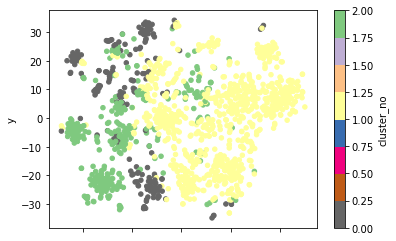

In [133]:
trial.plot.scatter(x='x',
                      y='y',
                      c='cluster_no',
                      colormap='Accent_r')

In [134]:
#Generating dataset for 3D Scatter Plot

'''trans = transform(n_components=3)
movie_embeddings_3d = trans.fit_transform(movie_embeddings)

movie_3D = pd.DataFrame(movie_embeddings_3d)
movie_3D.columns = ['D1', 'D2', 'D3']
movie_3D['cluster_no'] = list(K_means.labels_)


movie_3D.to_csv('movie_3D.csv')
files.download('movie_3D.csv')'''

"trans = transform(n_components=3)\nmovie_embeddings_3d = trans.fit_transform(movie_embeddings)\n\nmovie_3D = pd.DataFrame(movie_embeddings_3d)\nmovie_3D.columns = ['D1', 'D2', 'D3']\nmovie_3D['cluster_no'] = list(K_means.labels_)\n\n\nmovie_3D.to_csv('movie_3D.csv')\nfiles.download('movie_3D.csv')"